In [1]:
import math
import numpy as np
import ceo
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode()

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
N = 401
L = 25.0
tid = ceo.StopWatch()
delta = L/(N-1)
print delta

0.0625


## Single layer single source

In [4]:
atm = ceo.Atmosphere(15e-2,30,N_LAYER=1,altitude=[0e3],xi0=[1.0],
                     wind_speed=[10.0],wind_direction=[0],
                     L=L,NXY_PUPIL=N,fov=60.0)

In [5]:
src =ceo.Source('R',resolution=(N,N))

In [6]:
tel = ceo.Mask(N*N)
src.masked(tel)

In [7]:
tau = 0.0
src.reset()
tid.tic()
atm.get_phase_screen(src,delta,N,delta,N,tau)
tid.toc()
print "ET=%.4fms"%tid.elapsedTime
print src.wavefront.rms(-6)
ps1 = src.phase.host(units='micron')
#trace1 = go.Heatmap(z=src.phase.host(units='micron'))

ET=582.0114ms
[ 1.52979374]


In [8]:
tau = 0.0
src.reset()
tid.tic()
atm.ray_tracing(src,delta,N,delta,N,tau)
tid.toc()
print "ET=%.4fms"%tid.elapsedTime
print src.wavefront.rms(-6)
ps2 = src.phase.host(units='micron')
#trace2 = go.Heatmap(z=src.phase.host(units='micron'))

ET=0.2627ms
[ 1.52979374]


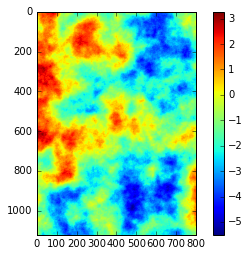

In [9]:
layer_phase_screen = atm.layers[0].phase_screen.host(units='micron')
imshow(layer_phase_screen)
colorbar()

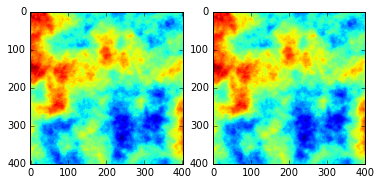

In [10]:
fig,(ax1,ax2) = subplots(nrows=1,ncols=2)
ax1.imshow(ps1,vmin=layer_phase_screen.min(),vmax=layer_phase_screen.max())
ax2.imshow(ps2,vmin=layer_phase_screen.min(),vmax=layer_phase_screen.max())

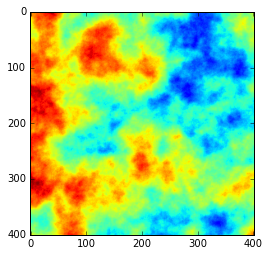

In [11]:
src.reset()
tid.tic()
atm.ray_tracing(src,delta,N,delta,N,1.0)
tid.toc()
ps = src.phase.host(units='micron')
imshow(ps,vmin=layer_phase_screen.min(),vmax=layer_phase_screen.max())

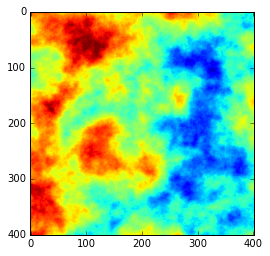

In [12]:
src.reset()
tid.tic()
atm.ray_tracing(src,delta,N,delta,N,2.1)
tid.toc()
ps = src.phase.host(units='micron')
imshow(ps,vmin=layer_phase_screen.min(),vmax=layer_phase_screen.max())

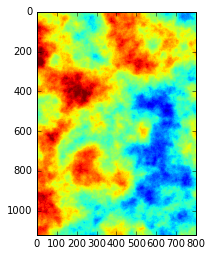

In [13]:
layer_phase_screen_1 = atm.layers[0].phase_screen.host(units='micron')
imshow(layer_phase_screen_1,vmin=layer_phase_screen.min(),vmax=layer_phase_screen.max())

In [12]:
nTau = 300
wfe_rms = np.zeros((2,nTau))
for k in range(nTau):
    tau = k*1e-2
    src.reset()
    atm.get_phase_screen(src,delta,N,delta,N,tau)
    wfe_rms[0,k] = src.wavefront.rms(-6)
    src.reset()
    atm.ray_tracing(src,delta,N,delta,N,tau)
    wfe_rms[1,k] = src.wavefront.rms(-6)

In [13]:
traces = []
traces.append( go.Trace(y=wfe_rms[0,:],name='Polar-log') )
traces.append( go.Trace(y=wfe_rms[1,:],name='Ray tracing') )
iplot(go.Data(traces))

In [14]:
trace = go.Trace(y=wfe_rms[0,:]-wfe_rms[1,:])
iplot(go.Data([trace]))

## Single layer @10km three sources

In [15]:
atm = ceo.Atmosphere(15e-2,30,N_LAYER=1,altitude=[10e3],xi0=[1.0],
                     wind_speed=[10.0],wind_direction=[0*math.pi/4],
                     L=L,NXY_PUPIL=N,fov=60.0*2)

In [4]:
src =ceo.Source('R',zenith=np.ones((1,3))*0.5*ceo.constants.ARCMIN2RAD,
                azimuth=np.arange(3)*2*math.pi/3,resolution=(N,N))
#src =ceo.Source('R',resolution=(N,N))
tel = ceo.Mask(N*N*src.N_SRC)
src.masked(tel)

In [17]:
tau = 0.0
src.reset()
tid.tic()
atm.get_phase_screen(src,delta,N,delta,N,tau)
tid.toc()
print "ET=%.4fms"%tid.elapsedTime
ps1 = src.phase.host(units='micron')
#trace1 = go.Heatmap(z=src.phase.host(units='micron'))
src.wavefront.rms(-6)

ET=1730.8435ms


array([ 1.51101608,  1.53293195,  1.62471372])

In [18]:
src.reset()
tid.tic()
atm.ray_tracing(src,delta,N,delta,N,tau)
tid.toc()
print "ET=%.4fms"%tid.elapsedTime
ps2 = src.phase.host(units='micron')
#trace2 = go.Heatmap(z=src.phase.host(units='micron'))
src.wavefront.rms(-6)

ET=0.7984ms


array([ 1.51071515,  1.53260839,  1.62439824])

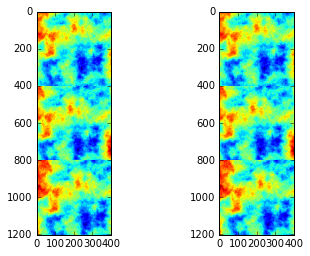

In [19]:
fig,(ax1,ax2) = subplots(nrows=1,ncols=2)
ax1.imshow(ps1)
ax2.imshow(ps2)

In [20]:
nTau = 300
wfe_rms = np.zeros((src.N_SRC,nTau))
for k in range(nTau):
    tau = k*1e-2
    src.reset()
    atm.ray_tracing(src,delta,N,delta,N,tau)
    wfe_rms[:,k] = src.wavefront.rms(-6)

In [21]:
traces = []
for k in range(src.N_SRC):
    traces.append( go.Trace(y=wfe_rms[k,:],name='Ray tracing #%d'%k) )
iplot(go.Data(traces))

In [22]:
xc = np.ravel(10e3*src.zenith*np.cos(src.azimuth))
yc = np.ravel(10e3*src.zenith*np.sin(src.azimuth))
x0 = -L/2+xc
y0 = -L/2+yc
tau = 0
print atm.layers[0].WIDTH
layer_phase_screen = atm.layers[0].phase_screen.host(units='micron')

30.84375


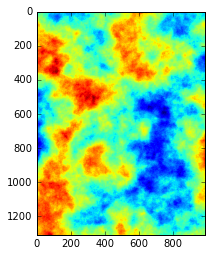

In [23]:
imshow(layer_phase_screen)

## Two layers three sources¶

In [24]:
atm = ceo.Atmosphere(15e-2,30,N_LAYER=2,altitude=[0,10e3],xi0=[0.7,0.3],
                     wind_speed=[10.0,20.0],wind_direction=[0,4*math.pi/3],
                     L=L,NXY_PUPIL=N,fov=60.0*2)

In [25]:
tau = 0.0
src.reset()
tid.tic()
atm.get_phase_screen(src,delta,N,delta,N,tau)
tid.toc()
print "ET=%.4fms"%tid.elapsedTime
src.wavefront.rms(-6)

ET=3052.8499ms


array([ 1.44275782,  1.63162315,  1.53455915])

In [26]:
tau = 0.0
src.reset()
tid.tic()
atm.ray_tracing(src,delta,N,delta,N,tau)
tid.toc()
print "ET=%.4fms"%tid.elapsedTime
src.wavefront.rms(-6)

ET=1.5070ms


array([ 1.40473742,  1.4817382 ,  1.42141937])

In [27]:
nTau = 300
wfe_rms = np.zeros((src.N_SRC,nTau))
for k in range(nTau):
    tau = k*1e-2
    src.reset()
    atm.ray_tracing(src,delta,N,delta,N,tau)
    wfe_rms[:,k] = src.wavefront.rms(-6)

In [28]:
traces = []
for k in range(src.N_SRC):
    traces.append( go.Trace(y=wfe_rms[k,:],name='Ray tracing #%d'%k) )
iplot(go.Data(traces))

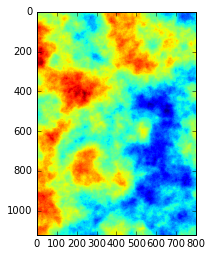

In [29]:
layer_phase_screen = atm.layers[0].phase_screen.host(units='micron')
imshow(layer_phase_screen)

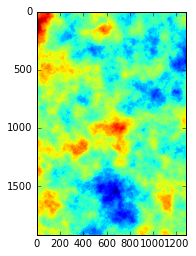

In [30]:
layer_phase_screen = atm.layers[1].phase_screen.host(units='micron')
imshow(layer_phase_screen)

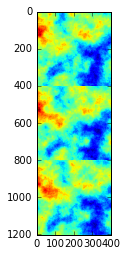

In [31]:
src.reset()
atm.ray_tracing(src,delta,N,delta,N,tau)
ps = src.phase.host(units='micron')
imshow(ps)

## GMT atmosphere

In [5]:
atm= ceo.GmtAtmosphere(15e-2,30,L=L,NXY_PUPIL=N,fov=60.0*2)

In [ ]:
nTau = 3000
wfe_rms = np.zeros((src.N_SRC,nTau))
tid.tic()
for k in range(nTau):
    tau = k*1e-2
    src.reset()
    atm.ray_tracing(src,delta,N,delta,N,tau)
    wfe_rms[:,k] = src.wavefront.rms(-6)
tid.toc()
print "ET=%.4fms"%tid.elapsedTime

In [8]:
traces = []
for k in range(src.N_SRC):
    traces.append( go.Trace(y=wfe_rms[k,:],name='Ray tracing #%d'%k) )
iplot(go.Data(traces))

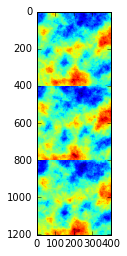

In [8]:
src.reset()
atm.ray_tracing(src,delta,N,delta,N,tau)
ps = src.phase.host(units='micron')
imshow(ps)